## Analysing Results 



#### Accuracy of baseline models and LGBMs

In [1]:
import  numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV

from sklearn.preprocessing import QuantileTransformer, quantile_transform

from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
# import lightgbm as lgb 

from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.pipeline import Pipeline, make_pipeline



from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
from sklearn import preprocessing 
import pickle
import joblib



%matplotlib inline

In [2]:
# Load label encoded data for LGBM
with open('cleaned_data_label_encoding.pickle', 'rb') as handle:
    background_imputed_tot = pickle.load(handle)
    
with open('X_train_label_encoding.pickle', 'rb') as handle:
    X_train = pickle.load(handle)

with open('X_CV_label_encoding.pickle', 'rb') as handle:
    X_CV = pickle.load(handle)

with open('x_test_label_encoding.pickle', 'rb') as handle:
    x_test = pickle.load(handle)
    
with open('x_leaderboard_label_encoding.pickle', 'rb') as handle:
    x_leaderboard = pickle.load(handle)
    
with open('y_train_label_encoding.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
    
with open('y_CV_label_encoding.pickle', 'rb') as handle:
    y_CV = pickle.load(handle)
    
background = pd.read_csv('FFChallenge_v5/background.csv', sep=',', header=0,index_col=0,low_memory=False)
# train.csv contains 2,121 rows (one per child in the training set) and 7 columns.
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0,low_memory=False)
########### Holdout dataset for internal testing only
test = pd.read_csv('test.csv',header=0, index_col=0,low_memory=False)
leaderboard = pd.read_csv('leaderboard.csv', header=0, index_col=0,low_memory=False)
leaderboard = leaderboard.dropna()

In [3]:
# Final stats and useful variables associated with each column

numerical_columns = [c for c,v in background_imputed_tot.dtypes.iteritems() if v in [np.float,np.int,np.int64]]
non_numerical_columns = [c for c,v in background_imputed_tot.dtypes.iteritems() if v not in [np.float,np.int,np.int64]]

# categorical_bools = background.copy().loc[:,(background.apply(pd.Series.nunique) < 15).values]

# The categorical columns are the intersection of both the non_numerical columns and the ones that have less than 15 distinct levels
# categorical_cols_lst = list(set(categorical_bools.columns).union(set(non_numerical_columns)))

continuous_cols_lst = list()
continuous_cols_lst = background_imputed_tot.T.loc[(background_imputed_tot.apply(pd.Series.nunique) >= 15).values==True].index.to_list()

non_continuous_lst = set(background_imputed_tot.columns.tolist())-set(continuous_cols_lst)


print('Number of continuous columns %s' % len(continuous_cols_lst))
# background = background[numerical_columns]
# background.head()

Number of continuous columns 601


In [4]:
# Dictionnary with accuracies of all models

accuracies_train_each_model = dict()
accuracies_cv_each_model = dict()
accuracies_leaderboard_each_model = dict()
accuracies_test_each_model = dict()

## Baseline models

In [5]:

variable_list = test.columns.to_list()

baseline_accuracies_leaderboard = dict()
baseline_accuracies_test = dict()

for variable in variable_list:
    baseline_accuracies = dict()
    
    print(variable)
    y_train_no_na = y_train[variable].dropna()
    X_train_no_na = X_train.loc[y_train_no_na.index.values]

    y_CV_no_na = y_CV[variable].dropna()
    X_CV_no_na = X_CV.loc[y_CV_no_na.index.values]

    mask = leaderboard[variable].isna()
    y_leaderboard = leaderboard[variable].dropna()
    # y_leaderboard = test[variable].dropna()



    y_test_trans = test[variable].dropna()
    # y_test_trans = (y_test_trans-y_train_mean)/y_train_std
    x_test_no_na = x_test.loc[y_test_trans.index.values]

    preds_baseline_leaderboard = np.array([train[variable].mean() for i in range(len(y_leaderboard))])
    baseline_accuracies_leaderboard[variable] = mean_squared_error(y_leaderboard,preds_baseline_leaderboard)
    print('Baseline leaderboard brier loss =',mean_squared_error(y_leaderboard,preds_baseline_leaderboard))

    preds_baseline_test = np.array([train[variable].mean()for i in range(len(y_test_trans))])
    baseline_accuracies_test[variable] = mean_squared_error(y_test_trans,preds_baseline_test)
    print('Baseline test brier loss =',mean_squared_error(y_test_trans,preds_baseline_test))
    
accuracies_leaderboard_each_model['baseline'] = baseline_accuracies_leaderboard
accuracies_test_each_model['baseline'] = baseline_accuracies_test
# accuracies_each_model[boosting_type] = lgbm_accuracies

gpa
Baseline leaderboard brier loss = 0.3927318839912321
Baseline test brier loss = 0.42514888086196334
grit
Baseline leaderboard brier loss = 0.21997439458397655
Baseline test brier loss = 0.25298359553631566
materialHardship
Baseline leaderboard brier loss = 0.028804479333216677
Baseline test brier loss = 0.024905616887417152
eviction
Baseline leaderboard brier loss = 0.05340894374196272
Baseline test brier loss = 0.05545791262088538
layoff
Baseline leaderboard brier loss = 0.174353876481935
Baseline test brier loss = 0.16722371798035746
jobTraining
Baseline leaderboard brier loss = 0.2022444777566772
Baseline test brier loss = 0.18532949215996594


## LGBM

In [6]:
variable = 'grit'
boosting_type = 'dart'

for boosting_type in ['gbdt','dart','goss']:
    lgbm_accuracies_leaderboard = dict()
    lgbm_accuracies_test = dict()
    lgbm_accuracies_train = dict()
    lgbm_accuracies_cv = dict()
    for i,variable in enumerate(variable_list):
        print(variable,boosting_type,'\n')
        lgbm = joblib.load('lgbm_'+ variable + '_' + boosting_type + '.pkl')


        y_train_no_na = y_train[variable].dropna()
        X_train_no_na = X_train.loc[y_train_no_na.index.values]

        y_CV_no_na = y_CV[variable].dropna()
        X_CV_no_na = X_CV.loc[y_CV_no_na.index.values]

        mask = leaderboard[variable].isna()
        y_leaderboard = leaderboard[variable]

        y_test_trans = test[variable].dropna()
        # y_test_trans = (y_test_trans-y_train_mean)/y_train_std
        x_test_no_na = x_test.loc[y_test_trans.index.values]

        if i <3:
            y_pred_train = lgbm.predict(X_train_no_na)
            y_pred_all = lgbm.predict(x_leaderboard)
            cv_preds = lgbm.predict(X_CV_no_na)
            test_preds = lgbm.predict(x_test_no_na)
            # Save predictions of best model for leaderboard submition
            pred_all_backgrounds = lgbm.predict(background_imputed_tot)
        else:
            y_pred_train = lgbm.predict_proba(X_train_no_na)[:,1]
            y_pred_all = lgbm.predict_proba(x_leaderboard)[:,1]
            cv_preds = lgbm.predict_proba(X_CV_no_na)[:,1]
            test_preds = lgbm.predict_proba(x_test_no_na)[:,1]
            pred_all_backgrounds = lgbm.predict_proba(background_imputed_tot)[:,1]

        # Note: Brier loss and MSE are the same when there is only 2 classes for categorical vars
        print('---- leaderboard error ----')
        print('mse =',mean_squared_error(y_leaderboard[~mask],y_pred_all[~mask]))

        print('---- test error ----')
        print('mse =',mean_squared_error(y_test_trans,test_preds))

        # Saving errors 
        lgbm_accuracies_train[variable] = mean_squared_error(y_train_no_na,y_pred_train)
        lgbm_accuracies_cv[variable] =mean_squared_error(y_CV_no_na,cv_preds)
        lgbm_accuracies_leaderboard[variable] = mean_squared_error(y_leaderboard[~mask],y_pred_all[~mask])
        lgbm_accuracies_test[variable] =mean_squared_error(y_test_trans,test_preds)
        print('\n\n\n')
    
    accuracies_train_each_model[boosting_type] = lgbm_accuracies_train
    accuracies_cv_each_model[boosting_type] = lgbm_accuracies_cv
    accuracies_leaderboard_each_model[boosting_type] = lgbm_accuracies_leaderboard
    accuracies_test_each_model[boosting_type] = lgbm_accuracies_test
    
    

gpa gbdt 

---- leaderboard error ----
mse = 0.37764382969532606
---- test error ----
mse = 0.3516925089590073




grit gbdt 

---- leaderboard error ----
mse = 0.21711522212374287
---- test error ----
mse = 0.2445699089468084




materialHardship gbdt 

---- leaderboard error ----
mse = 0.02609444653819857
---- test error ----
mse = 0.021069369302406545




eviction gbdt 

---- leaderboard error ----
mse = 0.050633443020071826
---- test error ----
mse = 0.05368701437375349




layoff gbdt 

---- leaderboard error ----
mse = 0.17419679113048317
---- test error ----
mse = 0.16711538260940284




jobTraining gbdt 

---- leaderboard error ----
mse = 0.19940966236005536
---- test error ----
mse = 0.17608817756493228




gpa dart 

---- leaderboard error ----
mse = 0.38124499706416043
---- test error ----
mse = 0.3566932526337692




grit dart 

---- leaderboard error ----
mse = 0.2169031608664567
---- test error ----
mse = 0.24401679455388908




materialHardship dart 

---- leaderboard er

## Getting Accuracies of Elastic net

In [7]:
# Load cleaned dummy variable data
with open('cleaned_data_dummy_vars.pickle', 'rb') as handle:
    background_imputed_tot = pickle.load(handle)
    
with open('X_train_dummy_vars.pickle', 'rb') as handle:
    X_train = pickle.load(handle)

with open('X_CV_dummy_vars.pickle', 'rb') as handle:
    X_CV = pickle.load(handle)

with open('x_test_dummy_vars.pickle', 'rb') as handle:
    x_test = pickle.load(handle)
    
with open('x_leaderboard_dummy_vars.pickle', 'rb') as handle:
    x_leaderboard = pickle.load(handle)
    
with open('y_train_dummy_vars.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
    
with open('y_CV_dummy_vars.pickle', 'rb') as handle:
    y_CV = pickle.load(handle)
    
background = pd.read_csv('FFChallenge_v5/background.csv', sep=',', header=0,index_col=0,low_memory=False)
# train.csv contains 2,121 rows (one per child in the training set) and 7 columns.
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0,low_memory=False)
########### Holdout dataset for internal testing only
test = pd.read_csv('test.csv',header=0, index_col=0,low_memory=False)
leaderboard = pd.read_csv('leaderboard.csv', header=0, index_col=0,low_memory=False)
leaderboard = leaderboard.dropna()

In [8]:
# Final stats and useful variables associated with each column

numerical_columns = [c for c,v in background_imputed_tot.dtypes.iteritems() if v in [np.float,np.int,np.int64]]
non_numerical_columns = [c for c,v in background_imputed_tot.dtypes.iteritems() if v not in [np.float,np.int,np.int64]]

# categorical_bools = background.copy().loc[:,(background.apply(pd.Series.nunique) < 15).values]

# The categorical columns are the intersection of both the non_numerical columns and the ones that have less than 15 distinct levels
# categorical_cols_lst = list(set(categorical_bools.columns).union(set(non_numerical_columns)))

continuous_cols_lst = list()
continuous_cols_lst = background_imputed_tot.T.loc[(background_imputed_tot.apply(pd.Series.nunique) >= 15).values==True].index.to_list()

In [9]:
train_errs = dict()
cv_errs = dict()
leaderboard_errs = dict()
test_errs = dict()

for i,variable in enumerate(variable_list):
    print('---------------variable:',variable,'---------------\n\n\n')
    # Get non-na rows for this specific variable
    y_train_no_na = y_train[variable].dropna()
    X_train_no_na = X_train.loc[y_train_no_na.index.values]

    y_CV_no_na = y_CV.copy()[variable].dropna()
    X_CV_no_na = X_CV.copy().loc[y_CV_no_na.index.values]

    mask = leaderboard[variable].isna()
    x_leaderboard = background_imputed_tot.loc[leaderboard.index.values]
    y_leaderboard = leaderboard[variable]
    x_leaderboard_no_na = x_leaderboard.loc[y_leaderboard.index]

    # y_train_trans= y_train_no_na.copy()

    # Standardizing outcome to be between 0 and 1 and apply the same transformation on the validation and test sets

    # y_train_trans = (y_train_no_na-y_train_mean)/y_train_std
    # y_CV_trans = y_CV_no_na.copy()
    # y_CV_trans = (y_CV_no_na-y_train_mean)/y_train_std
    y_CV_trans = y_CV_no_na.copy()

    # y_leaderboard = (y_leaderboard-y_train_mean)/y_train_std

    y_test_trans = test[variable].dropna()
    # y_test_trans = (y_test_trans-y_train_mean)/y_train_std
    x_test_no_na = x_test.loc[y_test_trans.index.values]



    ##### Standardizing features to be between 0 and 1 and apply the same transformation on the validation and test sets
    # Pandas applies these operations row-wise
    X_train_normalized = X_train_no_na.copy()
    X_cv_normalized = X_CV_no_na.copy()
    x_leaderboard_normalized = x_leaderboard_no_na.copy()




    ##### Normalize features to be between 0 and 1 and apply the same transformation on the validation and test sets
    # Pandas applies these operations row-wise
    X_train_standardized = X_train_no_na.copy()
    X_cv_standardized = X_CV_no_na.copy()
    x_leaderboard_standardized = x_leaderboard_no_na.copy()
    x_test_standardized = x_test_no_na.copy()

    # Standardising continuous columns to 0 mean, and std of 1
    column_mean_normalization = X_train_no_na[continuous_cols_lst].mean()
    column_std_normalization = X_train_no_na[continuous_cols_lst].std()


    X_train_standardized[continuous_cols_lst]= (X_train_no_na[continuous_cols_lst]-column_mean_normalization)\
    /(column_std_normalization)

    X_cv_standardized[continuous_cols_lst]=(X_CV_no_na[continuous_cols_lst]-column_mean_normalization)\
    /(column_std_normalization)

    x_leaderboard_standardized[continuous_cols_lst] = (x_leaderboard_no_na[continuous_cols_lst]-column_mean_normalization)\
    /(column_std_normalization)

    x_test_standardized[continuous_cols_lst] = (x_test_no_na[continuous_cols_lst]-column_mean_normalization)\
    /(column_std_normalization)

    model_elastic_net = joblib.load('elastic_net_' +variable +  '.pkl')

    # Continuous outcome predictions
    if i <3:
        y_pred_train = model_elastic_net.predict(X_train_standardized)
        y_pred_all = model_elastic_net.predict(x_leaderboard_standardized)
        cv_preds = model_elastic_net.predict(X_cv_standardized)
        test_preds = model_elastic_net.predict(x_test_standardized)

        # Now remove normalization for accurate comparison to baseline
        y_train_mean = y_train_no_na.mean()
        y_train_std = y_train_no_na.std()
        
        y_pred_train = (y_pred_train*y_train_std)+y_train_mean
        y_pred_all = (y_pred_all*y_train_std)+y_train_mean
        cv_preds = (cv_preds*y_train_std)+y_train_mean
        test_preds = (test_preds*y_train_std)+y_train_mean
    else:
        y_pred_train = model_elastic_net.predict_proba(X_train_standardized)[:,1]
        y_pred_all = model_elastic_net.predict_proba(x_leaderboard_standardized)[:,1]
        cv_preds = model_elastic_net.predict_proba(X_cv_standardized)[:,1]
        test_preds = model_elastic_net.predict_proba(x_test_standardized)[:,1]



    print('leaderboard MSE/brier score =:',mean_squared_error(y_leaderboard[~mask],y_pred_all[~mask]))
    print('Model test MSE/brier score =: ',mean_squared_error(test_preds,y_test_trans))
    
    train_errs[variable] = mean_squared_error(y_pred_train,y_train_no_na)
    cv_errs[variable] =mean_squared_error(cv_preds,y_CV_no_na)
    leaderboard_errs[variable] = mean_squared_error(y_leaderboard[~mask],y_pred_all[~mask])
    test_errs[variable] = mean_squared_error(test_preds,y_test_trans)
    
    # acc_nns[variable] = mean_squared_error(y_leaderboard[~mask],y_pred_all[~mask])
    print('\n\n\n\n')
    
accuracies_leaderboard_each_model['elastic_net'] = leaderboard_errs
accuracies_test_each_model['elastic_net'] = test_errs
accuracies_train_each_model['elastic_net'] = train_errs
accuracies_cv_each_model['elastic_net'] = test_errs

---------------variable: gpa ---------------



leaderboard MSE/brier score =: 0.3891345281145491
Model test MSE/brier score =:  0.36333806396146917





---------------variable: grit ---------------



leaderboard MSE/brier score =: 0.22145861769695668
Model test MSE/brier score =:  0.2493230872355555





---------------variable: materialHardship ---------------



leaderboard MSE/brier score =: 0.027679163942475802
Model test MSE/brier score =:  0.02331547241601272





---------------variable: eviction ---------------



leaderboard MSE/brier score =: 0.05228921042504571
Model test MSE/brier score =:  0.05339300604782738





---------------variable: layoff ---------------



leaderboard MSE/brier score =: 0.17493812539951997
Model test MSE/brier score =:  0.16588094171131537





---------------variable: jobTraining ---------------



leaderboard MSE/brier score =: 0.20188079209608278
Model test MSE/brier score =:  0.17827193865246238







## Accuracies of Neural Network Model

In [10]:
from keras.models import Sequential, load_model

train_errs = dict()
cv_errs = dict()
leaderboard_errs = dict()
test_errs = dict()
for i,variable in enumerate(variable_list):
    model_test = load_model(r'C:\Users\plize\Documents\GitHub\Term 2 Machine Learning\best_model_nn' + variable + '.h5')
    print('------------------------------Variable =',variable,'------------------------------')
    y_train_no_na = y_train[variable].dropna()
    X_train_no_na = X_train.loc[y_train_no_na.index.values]

    y_CV_no_na = y_CV.copy()[variable].dropna()
    X_CV_no_na = X_CV.copy().loc[y_CV_no_na.index.values]

    mask = leaderboard[variable].isna()
    x_leaderboard = background_imputed_tot.loc[leaderboard.index.values]
    y_leaderboard = leaderboard[variable]
    x_leaderboard_no_na = x_leaderboard.loc[y_leaderboard.index]

    y_train_trans= y_train_no_na.copy()
    y_CV_trans = y_CV_no_na.copy()
    y_test_trans = test[variable].dropna()


    x_test_no_na = x_test.loc[y_test_trans.index.values]



    ##### Normalize features to be between 0 and 1 and apply the same transformation on the validation and test sets
    # Pandas applies these operations row-wise
    X_train_normalized = X_train_no_na.copy()
    X_cv_normalized = X_CV_no_na.copy()
    x_leaderboard_normalized = x_leaderboard_no_na.copy()




    ##### Normalize features to be between 0 and 1 and apply the same transformation on the validation and test sets
    # Pandas applies these operations row-wise
    X_train_normalized = X_train_no_na.copy()
    X_cv_normalized = X_CV_no_na.copy()
    x_leaderboard_normalized = x_leaderboard_no_na.copy()
    x_test_normalized = x_test_no_na.copy()


    column_min_normalization = X_train_no_na[continuous_cols_lst].min()
    column_max_normalization = X_train_no_na[continuous_cols_lst].max()


    X_train_normalized[continuous_cols_lst]=(X_train_no_na[continuous_cols_lst]-column_min_normalization)\
    /(column_max_normalization-column_min_normalization)

    X_cv_normalized[continuous_cols_lst]=(X_CV_no_na[continuous_cols_lst]-column_min_normalization)\
    /(column_max_normalization-column_min_normalization)

    x_leaderboard_normalized[continuous_cols_lst] = (x_leaderboard_no_na[continuous_cols_lst]-column_min_normalization)\
    /(column_max_normalization-column_min_normalization)

    x_test_normalized[continuous_cols_lst] = (x_test_no_na[continuous_cols_lst]-column_min_normalization)\
    /(column_max_normalization-column_min_normalization)

    y_pred_train = model_test.predict(X_train_normalized)
    y_pred_cv = model_test.predict(X_cv_normalized)
    y_pred_all = model_test.predict(x_leaderboard_normalized)
    test_preds = model_test.predict(x_test_normalized)
    
    
    
    
    train_errs[variable] = mean_squared_error(y_pred_train,y_train_no_na)
    cv_errs[variable] = mean_squared_error(y_pred_cv,y_CV_no_na)
    leaderboard_errs[variable] = mean_squared_error(y_leaderboard[~mask],y_pred_all[~mask])
    test_errs[variable] = mean_squared_error(test_preds,y_test_trans)

    # Can use mean square error as performance metric for both, since for 1 output, the mean square error and brier loss are the same.
    print('leaderboard MSE/brier score =',mean_squared_error(y_leaderboard[~mask],y_pred_all[~mask]))        
    print('Model test MSE/brier score =',mean_squared_error(test_preds,y_test_trans))
    # acc_nns[variable] = mean_squared_error(y_leaderboard[~mask],y_pred_all[~mask])
    print('\n\n\n\n')
    
accuracies_train_each_model['Neural_net'] = train_errs 
accuracies_cv_each_model['Neural_net'] = cv_errs
accuracies_leaderboard_each_model['Neural_net'] = leaderboard_errs
accuracies_test_each_model['Neural_net'] = test_errs

------------------------------Variable = gpa ------------------------------
leaderboard MSE/brier score = 0.38765470734566604
Model test MSE/brier score = 0.3582977443513388





------------------------------Variable = grit ------------------------------
leaderboard MSE/brier score = 0.22050509139273994
Model test MSE/brier score = 0.25324822863695395





------------------------------Variable = materialHardship ------------------------------
leaderboard MSE/brier score = 0.02621333339933446
Model test MSE/brier score = 0.021285872750401114





------------------------------Variable = eviction ------------------------------
leaderboard MSE/brier score = 0.052046759997079695
Model test MSE/brier score = 0.0533792942733612





------------------------------Variable = layoff ------------------------------
leaderboard MSE/brier score = 0.1732015553528847
Model test MSE/brier score = 0.16653655600025682





------------------------------Variable = jobTraining --------------------------

## Displaying training and Validation set accuracies to show if models have a tendency to overfit

In [11]:
train_accs_df = pd.DataFrame(accuracies_train_each_model)
cv_accs_df = pd.DataFrame(accuracies_cv_each_model)

for model_type in ['gbdt','dart','goss','elastic_net','Neural_net']:
    print('Model =',model_type)
    df_acc_diff_training_cv = train_accs_df[[model_type]].merge(cv_accs_df[[model_type]],left_index = True, right_index = True,suffixes=(' Training Set',' Validation Set'))
    display(df_acc_diff_training_cv)
    df_acc_diff_training_cv.to_csv('train_val_accs_'+model_type+'.csv')
    print('\n\n\n')
# accuracies_cv_each_model

Model = gbdt


,gbdt Training Set,gbdt Validation Set
gpa,0.290306,0.372465
grit,0.188957,0.201308
materialHardship,0.021190,0.016857
eviction,0.048466,0.045477
layoff,0.167757,0.154564
jobTraining,0.162734,0.160712






Model = dart


,dart Training Set,dart Validation Set
gpa,0.188009,0.365776
grit,0.130705,0.209694
materialHardship,0.015494,0.016640
eviction,0.036431,0.046223
layoff,0.145679,0.155098
jobTraining,0.116861,0.161962






Model = goss


,goss Training Set,goss Validation Set
gpa,0.347722,0.383822
grit,0.230207,0.209214
materialHardship,0.019373,0.017245
eviction,0.051432,0.046945
layoff,0.145679,0.155098
jobTraining,0.139329,0.164777






Model = elastic_net


,elastic_net Training Set,elastic_net Validation Set
gpa,0.328690,0.363338
grit,0.153560,0.249323
materialHardship,0.004149,0.023315
eviction,0.049183,0.053393
layoff,0.154831,0.165881
jobTraining,0.160666,0.178272






Model = Neural_net


,Neural_net Training Set,Neural_net Validation Set
gpa,0.226606,0.370409
grit,0.241265,0.212870
materialHardship,0.004309,0.017984
eviction,0.042821,0.047190
layoff,0.133945,0.151974
jobTraining,0.101370,0.166339


In [30]:
# Showing hyperparameters used by the neural network to include in Table 3 of my report (I'm including the dropout rate)

with open(r'best_params_nn_dict.pickle', 'rb') as handle:
    best_params_nn = pickle.load(handle)
pd.DataFrame(best_params_nn).T



,dropout_layer_1,learning_rate,num_hidden_layer_1
gpa,0.75,0.000500,1024.0
grit,0.85,0.002000,1024.0
materialHardship,0.75,0.000100,1024.0
eviction,0.90,0.000025,64.0
jobTraining,0.80,0.000025,64.0
layoff,0.95,0.000025,256.0


## Displaying Accuracies on Leaderboard and test sets

In [12]:
print('--------------------------- Leaderboard performance ---------------------------')
display(pd.DataFrame(accuracies_leaderboard_each_model))
print('\n\n\n')
print('--------------------------- Test set performance ---------------------------')
display(pd.DataFrame(accuracies_test_each_model))

--------------------------- Leaderboard performance ---------------------------


,baseline,gbdt,dart,goss,elastic_net,Neural_net
gpa,0.392732,0.377644,0.381245,0.371065,0.389135,0.387655
grit,0.219974,0.217115,0.216903,0.216590,0.221459,0.220505
materialHardship,0.028804,0.026094,0.025560,0.026143,0.027679,0.026213
eviction,0.053409,0.050633,0.052073,0.051928,0.052289,0.052047
layoff,0.174354,0.174197,0.174404,0.174404,0.174938,0.173202
jobTraining,0.202244,0.199410,0.204283,0.203294,0.201881,0.201190






--------------------------- Test set performance ---------------------------


,baseline,gbdt,dart,goss,elastic_net,Neural_net
gpa,0.425149,0.351693,0.356693,0.372047,0.363338,0.358298
grit,0.252984,0.244570,0.244017,0.248635,0.249323,0.253248
materialHardship,0.024906,0.021069,0.019664,0.021134,0.023315,0.021286
eviction,0.055458,0.053687,0.053327,0.053797,0.053393,0.053379
layoff,0.167224,0.167115,0.166934,0.166934,0.165881,0.166537
jobTraining,0.185329,0.176088,0.175688,0.176514,0.178272,0.180002


## Dispalying accuracies of weighted and unweighted classes on the leaderboard set

In [13]:
with open('best_accs_trees_weighted.pickle', 'rb') as handle:
    best_accs_weighted_lgbm_models = pickle.load(handle)

In [14]:
accs_weighted_leaderboard = dict()
for selected_model in best_accs_weighted_lgbm_models.keys():
    weighted_var_accs = dict()
    for variable in best_accs_weighted_lgbm_models[selected_model].keys():
        weighted_var_accs[variable] = best_accs_weighted_lgbm_models[selected_model][variable]['leaderboard']
#         print(best_accs_weighted_lgbm_models[selected_model][variable]['leaderboard'])
    
    accs_weighted_leaderboard[selected_model+'_weighted'] = weighted_var_accs
accs_weighted_leaderboard_df = pd.DataFrame(accs_weighted_leaderboard)

In [15]:
tree_errors_comparison_weighted = (pd.DataFrame(accuracies_leaderboard_each_model))[['gbdt','dart','goss']].merge(accs_weighted_leaderboard_df,left_index = True, right_index = True, how = 'inner')
display(tree_errors_comparison_weighted)

,gbdt,dart,goss,gbdt_weighted,dart_weighted,goss_weighted
eviction,0.050633,0.052073,0.051928,0.052569,0.053157,0.052061
layoff,0.174197,0.174404,0.174404,0.175055,0.176640,0.176173
jobTraining,0.199410,0.204283,0.203294,0.211877,0.211803,0.204138


# Interpretting best performing models using SHAP
Since the best performing models appear to be the tree-based models, I will be interpretting the best performing tree-based model for each metric

In [16]:
# Load label encoded data for LGBM
with open('cleaned_data_label_encoding.pickle', 'rb') as handle:
    background_imputed_tot = pickle.load(handle)
    
with open('X_train_label_encoding.pickle', 'rb') as handle:
    X_train = pickle.load(handle)

with open('X_CV_label_encoding.pickle', 'rb') as handle:
    X_CV = pickle.load(handle)

with open('x_test_label_encoding.pickle', 'rb') as handle:
    x_test = pickle.load(handle)
    
with open('x_leaderboard_label_encoding.pickle', 'rb') as handle:
    x_leaderboard = pickle.load(handle)
    
with open('y_train_label_encoding.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
    
with open('y_CV_label_encoding.pickle', 'rb') as handle:
    y_CV = pickle.load(handle)
    
background = pd.read_csv('FFChallenge_v5/background.csv', sep=',', header=0,index_col=0,low_memory=False)
# train.csv contains 2,121 rows (one per child in the training set) and 7 columns.
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0,low_memory=False)
########### Holdout dataset for internal testing only
test = pd.read_csv('test.csv',header=0, index_col=0,low_memory=False)
leaderboard = pd.read_csv('leaderboard.csv', header=0, index_col=0,low_memory=False)
leaderboard = leaderboard.dropna()

In [17]:
# Final stats and useful variables associated with each column

numerical_columns = [c for c,v in background_imputed_tot.dtypes.iteritems() if v in [np.float,np.int,np.int64]]
non_numerical_columns = [c for c,v in background_imputed_tot.dtypes.iteritems() if v not in [np.float,np.int,np.int64]]

# categorical_bools = background.copy().loc[:,(background.apply(pd.Series.nunique) < 15).values]

# The categorical columns are the intersection of both the non_numerical columns and the ones that have less than 15 distinct levels
# categorical_cols_lst = list(set(categorical_bools.columns).union(set(non_numerical_columns)))

continuous_cols_lst = list()
continuous_cols_lst = background_imputed_tot.T.loc[(background_imputed_tot.apply(pd.Series.nunique) >= 15).values==True].index.to_list()

non_continuous_lst = set(background_imputed_tot.columns.tolist())-set(continuous_cols_lst)


print('Number of continuous columns %s' % len(continuous_cols_lst))
# background = background[numerical_columns]
# background.head()

Number of continuous columns 601


### Getting variable descriptions from codebook

In [18]:
# Getting variable descriptions from codebook
file = open(r'C:\Users\plize\Documents\GitHub\Term 2 Machine Learning\FFChallenge_v5\codebook_FFChallenge.txt')
line = file.read().replace("\n", " ")
file.close()

split_lines = line.split('---------------------------------------------------')

split_lines[14]

a = list()
for vals in split_lines:
    if len(vals) > 1:
        a.append(vals.strip('-'))

del a[0]
# del a[26054]
del a[26053]

print(a[26052].split('    '))

lst_vars_description = list()
for i in range(int(len(a)/2)):
    seperated_string = a[2*i].split('    ')
    lst_vars_description.append([seperated_string[0][1:],seperated_string[-1][:]])

    
# for i in range(10):
#     print(lst_vars_description[i])
# for i in

df_descriptions = pd.DataFrame(lst_vars_description,columns=['var','description'])
df_descriptions = df_descriptions.set_index('var')
df_descriptions = df_descriptions.iloc[1:]

lst1 = df_descriptions.index.to_list()
vars_tree = X_train.iloc[0:1].T
descriptions_tree_vars = vars_tree.merge(df_descriptions, left_index = True, right_index = True, how = 'inner')

[' k5f1', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '   First principal component scale created from k5f1 responses ']


In [19]:

import matplotlib.pyplot as plt

descriptions_lst = descriptions_tree_vars['description'].to_list()
descriptions_split = [descrip.split(' ') for descrip in descriptions_lst]
# descriptions_split = [w for d in descriptions_split for w in d if len(w)>0]


descriptions_spacing = list()
for d in descriptions_split:
    i = 0
    for word in d:
        if len(word)>0:
            if i==0:
                words = word
            elif i%6==0 and i > 4 :
                words = words + ' ' + word + '\n'
            else:
                words = words + ' ' + word
            i = i + 1
    descriptions_spacing.append(words)

# Mapping variable name to a description of the variable to understand what question was asked during the questionnair
# descriptions_lst = [re.sub("(.{25})", "\\1\n", label, 0, re.DOTALL) for label in descriptions_lst]
var_names_lst = descriptions_tree_vars.index.to_list()
mapping_description_var_name = {var_names_lst[i]:descriptions_spacing[i] for i in range(len(descriptions_spacing))}

## Plotting Shap Values of best model for GPA

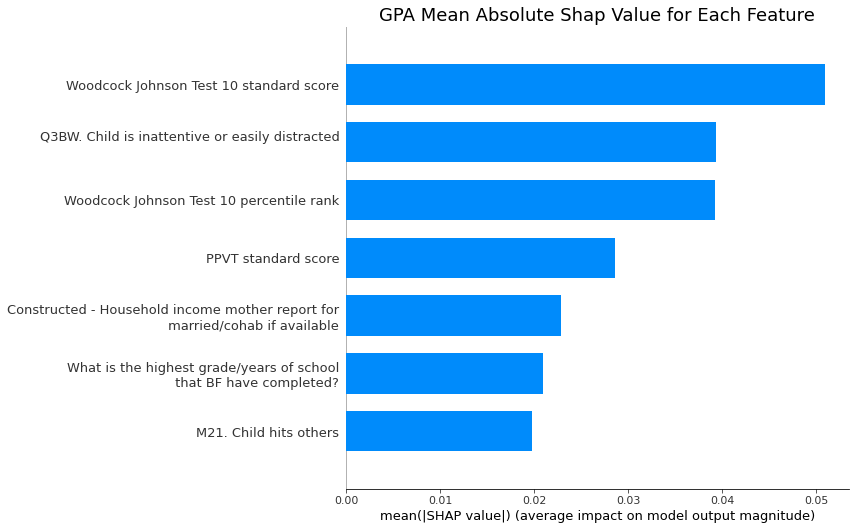

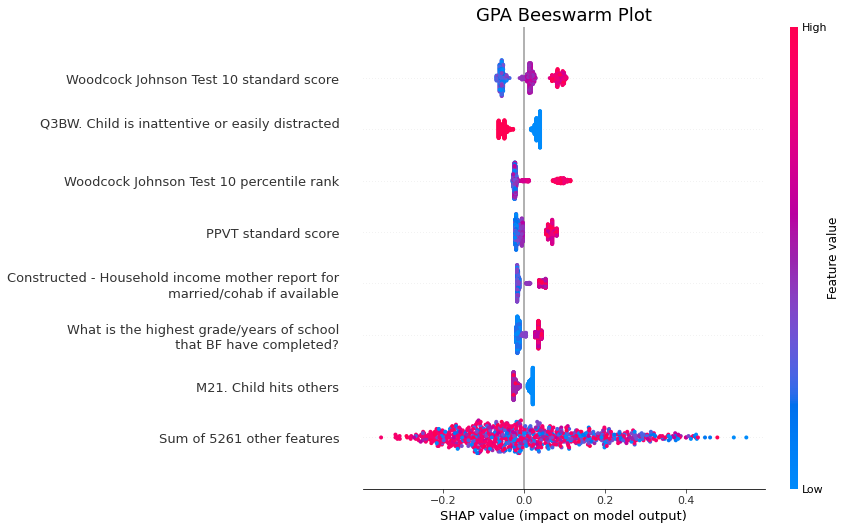

In [37]:
import shap
import matplotlib
variable = 'gpa'

# Best model for GPA was gbdt
lgbm = joblib.load('lgbm_'+ variable + '_' + 'gbdt' + '.pkl')
y_train_no_na = y_train[variable].dropna()
X_train_no_na = X_train.loc[y_train_no_na.index.values]

y_CV_no_na = y_CV[variable].dropna()
X_CV_no_na = X_CV.loc[y_CV_no_na.index.values]

mask = leaderboard[variable].isna()
y_leaderboard = leaderboard[variable]

y_test_trans = test[variable].dropna()
# y_test_trans = (y_test_trans-y_train_mean)/y_train_std
x_test_no_na = x_test.loc[y_test_trans.index.values]

x_test_w_var_descriptions = x_test_no_na.rename(columns=mapping_description_var_name)

explainer = shap.Explainer(lgbm, x_test_w_var_descriptions)
shap_values = explainer(x_test_w_var_descriptions)
shap.summary_plot(shap_values, x_test_w_var_descriptions, plot_type = "bar",max_display=7,show=False)
plt.title("GPA Mean Absolute Shap Value for Each Feature", fontsize=18)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8.5)
plt.show()
shap.plots.beeswarm(shap_values,max_display=8,show=False)
plt.title("GPA Beeswarm Plot", fontsize=18)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8.5)
plt.show()

## Plotting Shap Values of best model for Grit

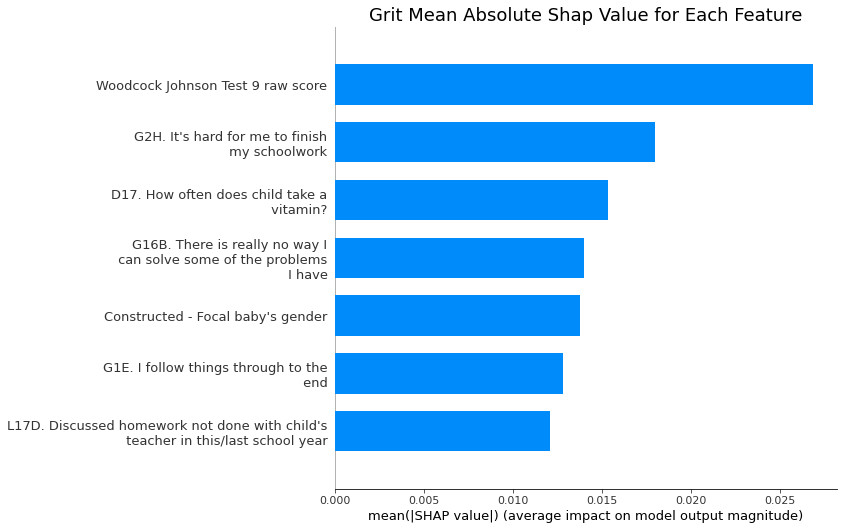

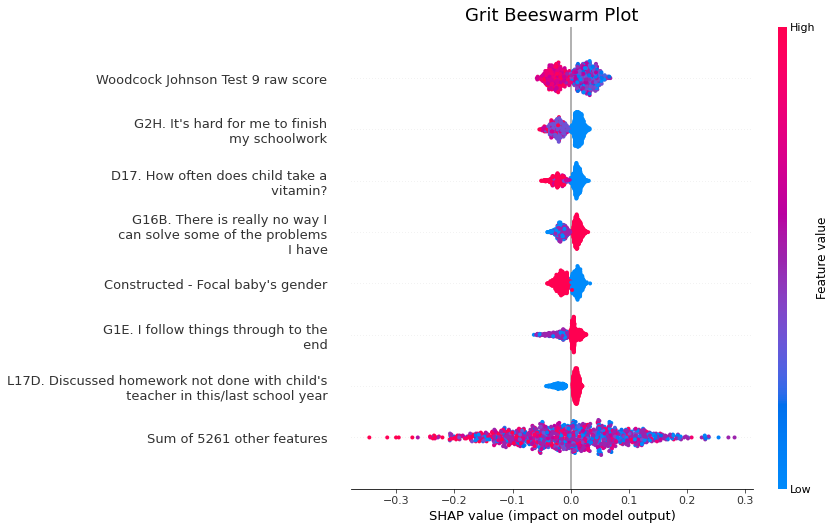

In [38]:
variable = 'grit'

# Best model for grit was dart
lgbm = joblib.load('lgbm_'+ variable + '_' + 'dart' + '.pkl')
y_train_no_na = y_train[variable].dropna()
X_train_no_na = X_train.loc[y_train_no_na.index.values]

y_CV_no_na = y_CV[variable].dropna()
X_CV_no_na = X_CV.loc[y_CV_no_na.index.values]

mask = leaderboard[variable].isna()
y_leaderboard = leaderboard[variable]

y_test_trans = test[variable].dropna()
# y_test_trans = (y_test_trans-y_train_mean)/y_train_std
x_test_no_na = x_test.loc[y_test_trans.index.values]

x_test_w_var_descriptions = x_test_no_na.rename(columns=mapping_description_var_name)

explainer = shap.Explainer(lgbm, x_test_w_var_descriptions)
shap_values = explainer(x_test_w_var_descriptions)
shap.summary_plot(shap_values, x_test_w_var_descriptions, plot_type = "bar",max_display=7,show=False)
plt.title("Grit Mean Absolute Shap Value for Each Feature", fontsize=18)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8.5)
plt.show()
shap.plots.beeswarm(shap_values,max_display=8,show=False)
plt.title("Grit Beeswarm Plot", fontsize=18)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8.5)
plt.show()

## Plotting Shap Values of best model for Material Hardship

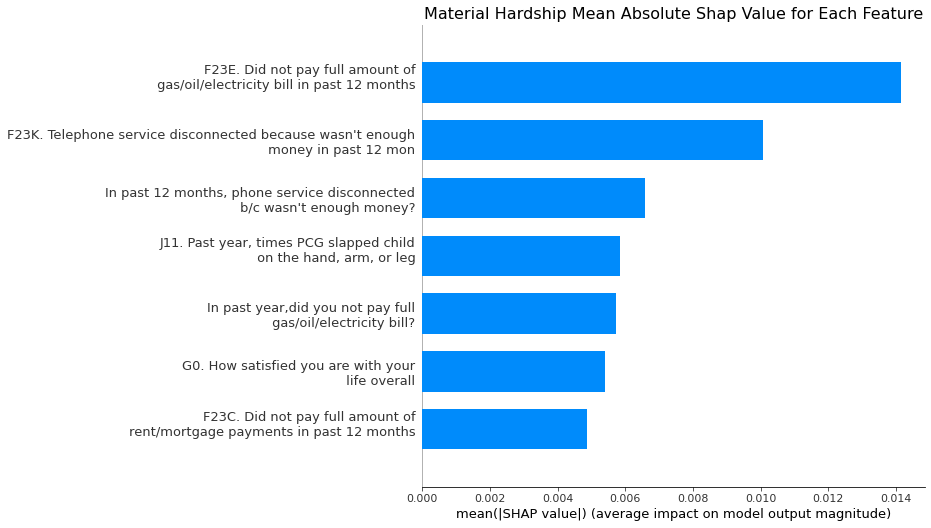

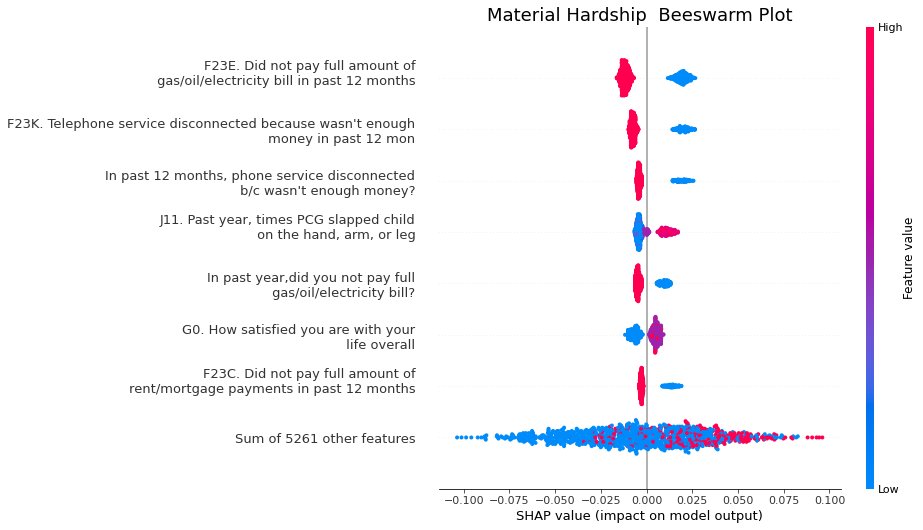

In [39]:
variable = 'materialHardship'

# Best model for material heardship was dart
lgbm = joblib.load('lgbm_'+ variable + '_' + 'dart' + '.pkl')
y_train_no_na = y_train[variable].dropna()
X_train_no_na = X_train.loc[y_train_no_na.index.values]

y_CV_no_na = y_CV[variable].dropna()
X_CV_no_na = X_CV.loc[y_CV_no_na.index.values]

mask = leaderboard[variable].isna()
y_leaderboard = leaderboard[variable]

y_test_trans = test[variable].dropna()
# y_test_trans = (y_test_trans-y_train_mean)/y_train_std
x_test_no_na = x_test.loc[y_test_trans.index.values]

x_test_w_var_descriptions = x_test_no_na.rename(columns=mapping_description_var_name)

explainer = shap.Explainer(lgbm, x_test_w_var_descriptions)
shap_values = explainer(x_test_w_var_descriptions)
shap.summary_plot(shap_values, x_test_w_var_descriptions, plot_type = "bar",max_display=7,show=False)
plt.title("Material Hardship Mean Absolute Shap Value for Each Feature", fontsize=16)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8.5)
plt.show()
shap.plots.beeswarm(shap_values,max_display=8,show=False)
plt.title("Material Hardship  Beeswarm Plot", fontsize=18)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8.5)
plt.show()

## Plotting Shap Values of best model for Material Hardship

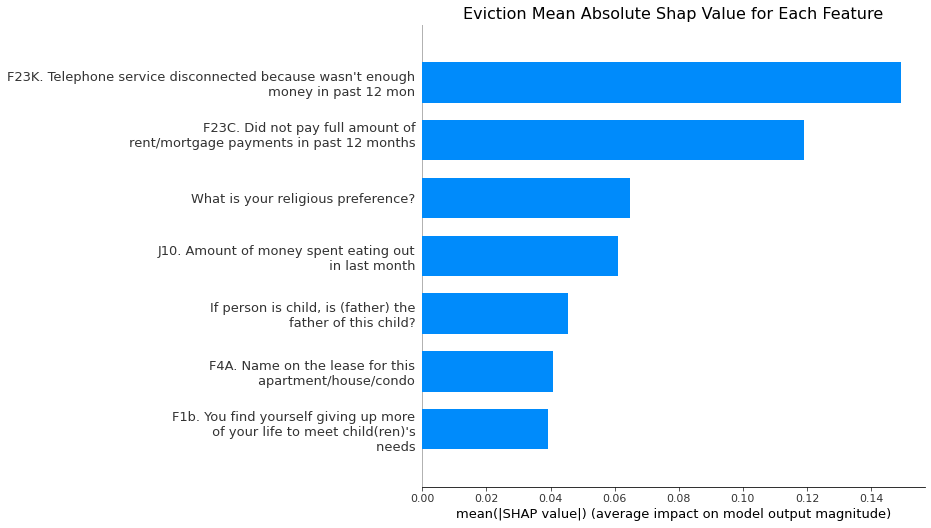

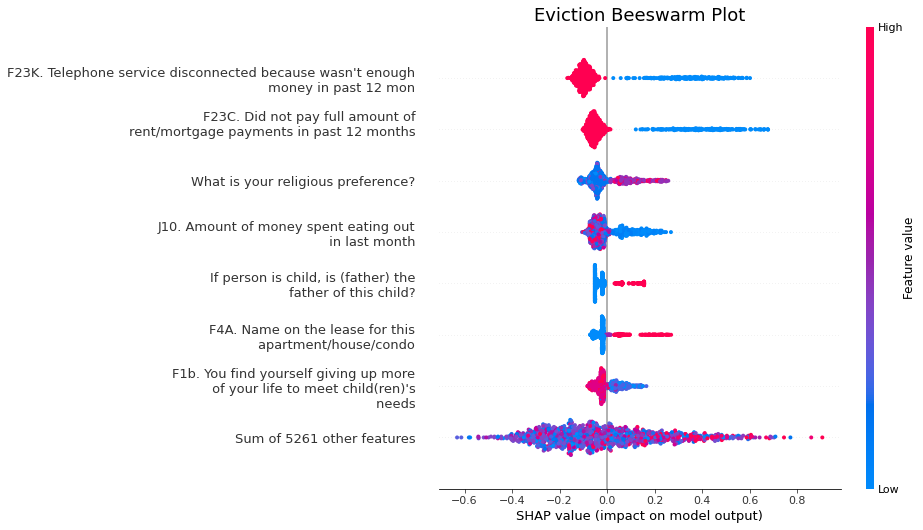

In [40]:
variable = 'eviction'

# Best model for eviction was dart
lgbm = joblib.load('lgbm_'+ variable + '_' + 'dart' + '.pkl')
y_train_no_na = y_train[variable].dropna()
X_train_no_na = X_train.loc[y_train_no_na.index.values]

y_CV_no_na = y_CV[variable].dropna()
X_CV_no_na = X_CV.loc[y_CV_no_na.index.values]

mask = leaderboard[variable].isna()
y_leaderboard = leaderboard[variable]

y_test_trans = test[variable].dropna()
# y_test_trans = (y_test_trans-y_train_mean)/y_train_std
x_test_no_na = x_test.loc[y_test_trans.index.values]

x_test_w_var_descriptions = x_test_no_na.rename(columns=mapping_description_var_name)

explainer = shap.Explainer(lgbm, x_test_w_var_descriptions)
shap_values = explainer(x_test_w_var_descriptions)
shap.summary_plot(shap_values, x_test_w_var_descriptions, plot_type = "bar",max_display=7,show=False)
plt.title("Eviction Mean Absolute Shap Value for Each Feature", fontsize=16)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8.5)
plt.show()
shap.plots.beeswarm(shap_values,max_display=8,show=False)
plt.title("Eviction Beeswarm Plot", fontsize=18)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8.5)
plt.show()

## Plotting Shap Values of best model for Layoff

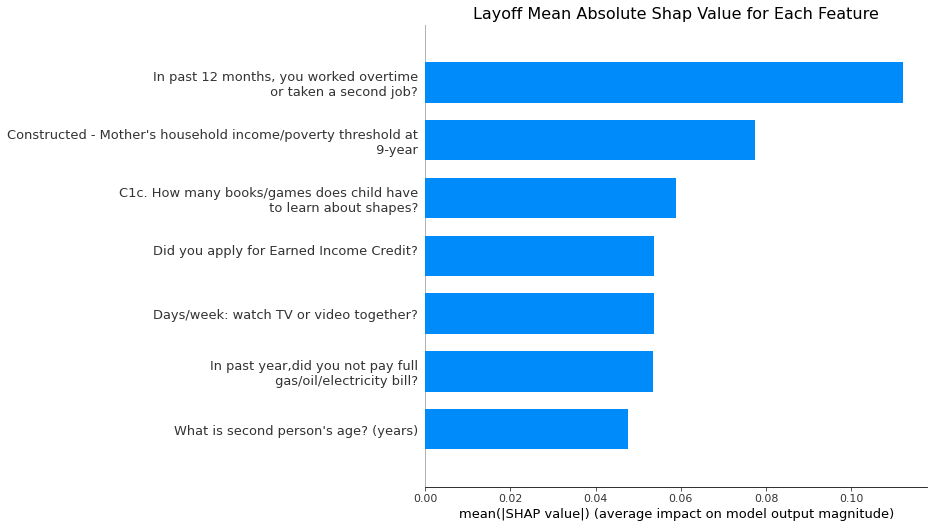

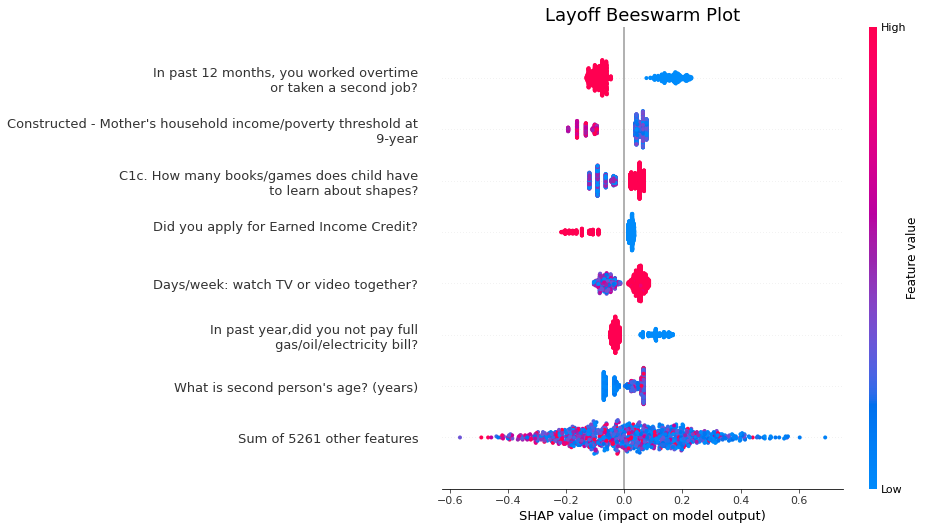

In [41]:
variable = 'layoff'

# Best model for layoff was goss
lgbm = joblib.load('lgbm_'+ variable + '_' + 'goss' + '.pkl')
y_train_no_na = y_train[variable].dropna()
X_train_no_na = X_train.loc[y_train_no_na.index.values]

y_CV_no_na = y_CV[variable].dropna()
X_CV_no_na = X_CV.loc[y_CV_no_na.index.values]

mask = leaderboard[variable].isna()
y_leaderboard = leaderboard[variable]

y_test_trans = test[variable].dropna()
# y_test_trans = (y_test_trans-y_train_mean)/y_train_std
x_test_no_na = x_test.loc[y_test_trans.index.values]

x_test_w_var_descriptions = x_test_no_na.rename(columns=mapping_description_var_name)

explainer = shap.Explainer(lgbm, x_test_w_var_descriptions)
shap_values = explainer(x_test_w_var_descriptions)
shap.summary_plot(shap_values, x_test_w_var_descriptions, plot_type = "bar",max_display=7,show=False)
plt.title("Layoff Mean Absolute Shap Value for Each Feature", fontsize=16)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8.5)
plt.show()
shap.plots.beeswarm(shap_values,max_display=8,show=False)
plt.title("Layoff Beeswarm Plot", fontsize=18)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8.5)
plt.show()

## Plotting Shap Values of best model for Layoff

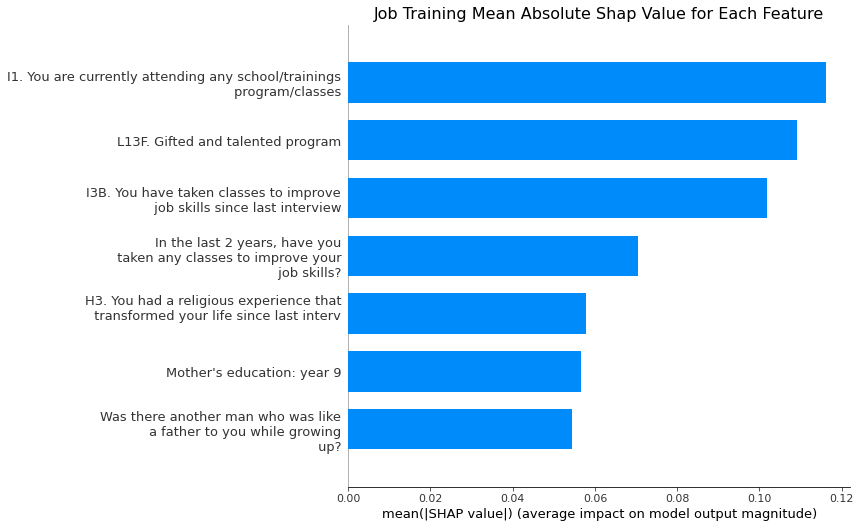

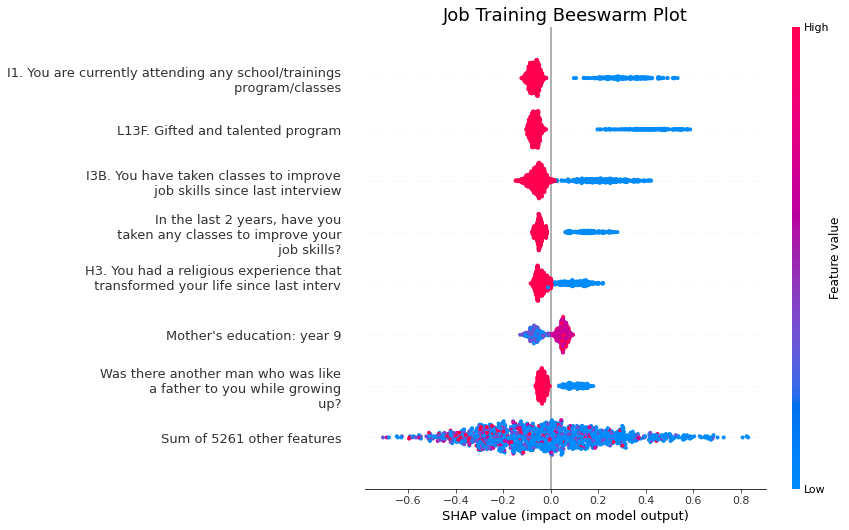

In [42]:
variable = 'jobTraining'

# Best model for job training was dart
lgbm = joblib.load('lgbm_'+ variable + '_' + 'dart' + '.pkl')
y_train_no_na = y_train[variable].dropna()
X_train_no_na = X_train.loc[y_train_no_na.index.values]

y_CV_no_na = y_CV[variable].dropna()
X_CV_no_na = X_CV.loc[y_CV_no_na.index.values]

mask = leaderboard[variable].isna()
y_leaderboard = leaderboard[variable]

y_test_trans = test[variable].dropna()
# y_test_trans = (y_test_trans-y_train_mean)/y_train_std
x_test_no_na = x_test.loc[y_test_trans.index.values]

x_test_w_var_descriptions = x_test_no_na.rename(columns=mapping_description_var_name)

explainer = shap.Explainer(lgbm, x_test_w_var_descriptions)
shap_values = explainer(x_test_w_var_descriptions)
shap.summary_plot(shap_values, x_test_w_var_descriptions, plot_type = "bar",max_display=7,show=False)
plt.title("Job Training Mean Absolute Shap Value for Each Feature", fontsize=16)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8.5)
plt.show()
shap.plots.beeswarm(shap_values,max_display=8,show=False)
plt.title("Job Training Beeswarm Plot", fontsize=18)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8.5)
plt.show()